# Gaussian Process using Tanimoto kernel

In [13]:
from __future__ import division
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rpy2 import robjects
from rpy2.robjects.packages import importr
from pandas import Series, DataFrame
from sklearn.metrics import r2_score
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(16, 8)

# Load and adjust data

In [14]:
df_train = pd.read_csv('../data/TableS2_training_pubchem.csv', keep_default_na=False)
df_test = pd.read_csv('../data/TableS3_training_pubchem.csv', keep_default_na=False)

columns = ['Name', 'Short Name', 'InChI', 'RRF_Measured', 'RRF_Predicted']
df_train = df_train[df_train['Annotation'] == '']
df_train = df_train[columns]
df_test = df_test[columns]

In [15]:
for df in [df_train, df_test]:
    df['RRF_Measured'] = df['RRF_Measured'] * 1e-2
    df['RRF_Predicted'] = df['RRF_Predicted'] * 1e-2
    df['mol'] = df['InChI'].apply(lambda x: Chem.MolFromInchi(x))

In [16]:
# Import RChemCpp
rchemcpp = importr("Rchemcpp")

In [17]:
def execute_tanimoto(X_train, y_train, X_test, alg_params):
    # Create SDF files that will be used for the kernels
    for df, file_name in zip([X_train, X_test], ['_train.sdf', '_test.sdf']):
        w = Chem.SDWriter('../data/' + file_name)
        try:
            for mol in df['mol']:
                w.write(mol)
            w.flush()
        finally:
            w.close()
            
    train_sdf_path = os.path.abspath('../data/_train.sdf')
    test_sdf_path = os.path.abspath('../data/_test.sdf')
    
    # Compute kernel
    rK = rchemcpp.sd2gramSpectrum(train_sdf_path, **alg_params)
    rKx = rchemcpp.sd2gramSpectrum(train_sdf_path, test_sdf_path, **alg_params)
    rK_ = rchemcpp.sd2gramSpectrum(test_sdf_path, **alg_params)
    
    K = np.array(rK)
    Kx = np.array(rKx)
    K_ = np.array(rK_)
                  
    # Gaussian Process
    s = 0.00005 # noise variance.

    L = np.linalg.cholesky(K + s * np.eye(np.size(K, axis=0)))

    # compute the mean at our test points.
    Lk = np.linalg.solve(L, Kx)
    mu = np.dot(Lk.T, np.linalg.solve(L, y_train))

    # compute the variance at our test points.
    s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
    s = np.sqrt(s2)
    
    return mu, s

def plot_results(y_test, mu, s, title='New Model'):
    r2 = r2_score(y_test, mu)

    plt.xlabel('Measured')
    plt.ylabel('New Predicted')
    plt.scatter(y_test, mu)
    
    ylim = plt.ylim()
    plt.errorbar(y_test, mu, yerr=s, fmt='o')
    plt.ylim(*ylim)
    
    xlim = plt.xlim()
    plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
    plt.xlim(*xlim)
    
    plt.grid(True)
    plt.title(title + ' $R^2$={:.4f}'.format(r2))

Mean log-likelihood: -47.731


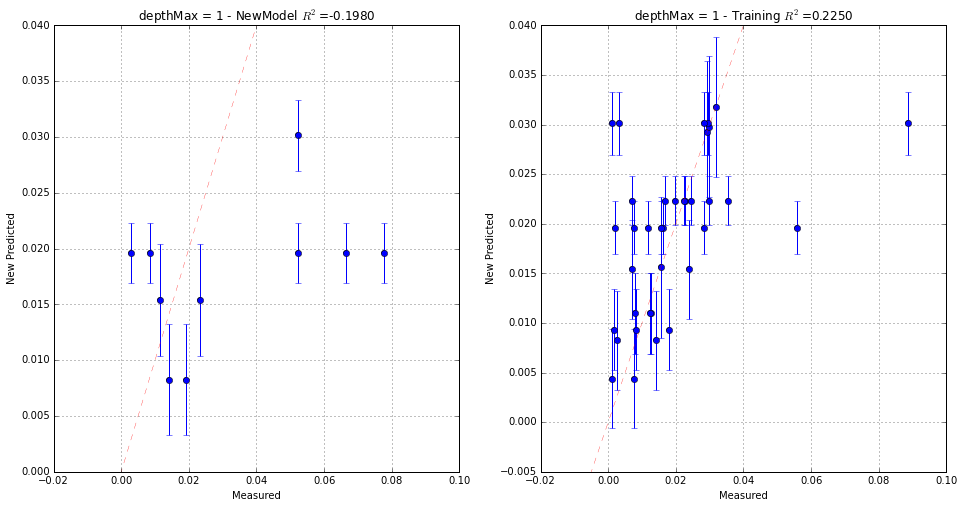

Mean log-likelihood: 1.122


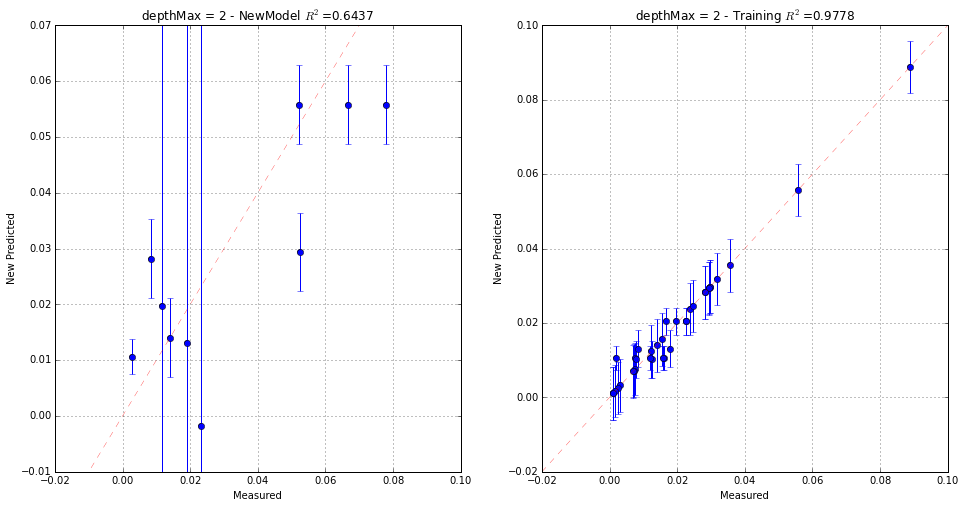

Mean log-likelihood: 1.162


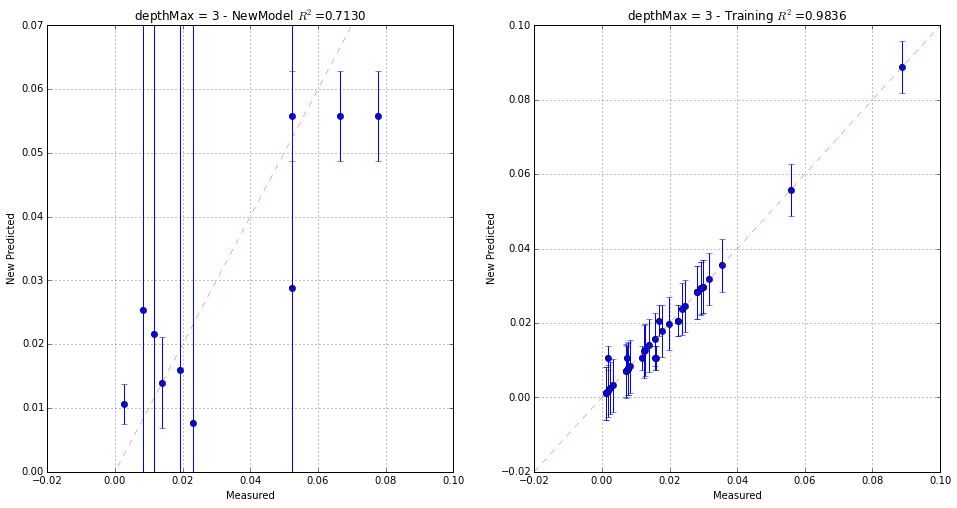

Mean log-likelihood: 1.046


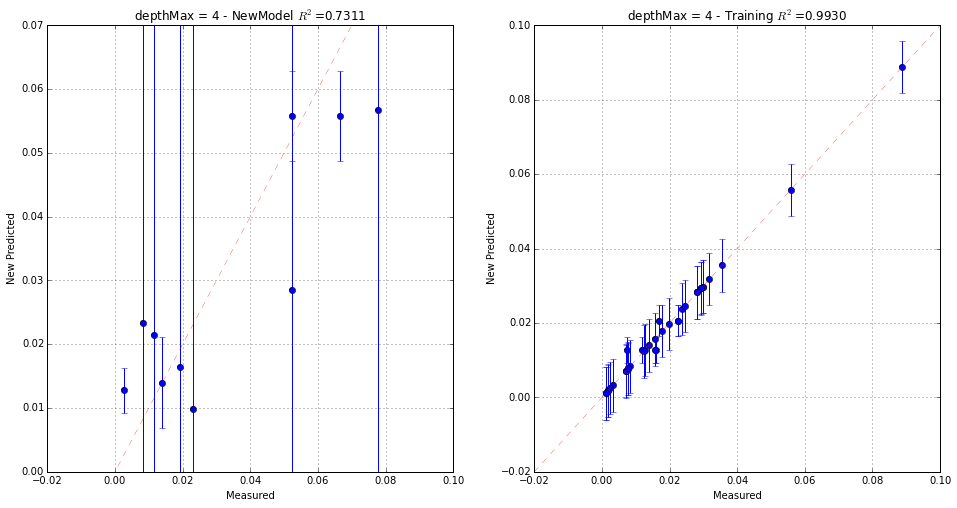

In [18]:
from scipy.stats import norm

for l in [1, 2, 3, 4]:
    params = {
        'kernelType': 'tanimoto', # other option: minmaxTanimoto
        'silentMode': True, # default: False
        'depthMax': l # default: 3
    }

    mu, s = execute_tanimoto(df_train, df_train['RRF_Measured'], df_test, params)
    
    likelihoods = [norm.pdf(t[0], loc=t[1], scale=t[2]) for t in zip(df_test['RRF_Measured'], mu, s)]
    print("Mean log-likelihood: {:.3f}".format(np.mean(np.log(likelihoods))))
    
    train_mu, train_s = execute_tanimoto(df_train, df_train['RRF_Measured'], df_train, params)

    plt.subplot(1, 2, 1)
    plot_results(df_test['RRF_Measured'], mu, s, title='depthMax = {} - NewModel'.format(l))
    plt.subplot(1, 2, 2)
    plot_results(df_train['RRF_Measured'], train_mu, train_s, title='depthMax = {} - Training'.format(l))

    plt.show()